In [1]:
import torchvision
import numpy as np
from torch.utils import data
from matplotlib import pyplot as plt
import cv2
import torchvision.transforms.v2 as transforms
from collections import defaultdict
import PIL
import torch
from torch.utils import data
import torch.nn as nn
from torchsummary import summary
from collections import OrderedDict
import torch.nn.functional as F
from loss import CenternetTTFLoss
from encoder import CenternetEncoder
from visualizer import get_image_with_bboxes
from torch.utils.data import Subset

%load_ext autoreload
%autoreload 2

print("GPU is available: ", torch.cuda.is_available() )

GPU is available:  False


In [2]:
input_height = input_width = 256
down_ratio = 4 # model output compared to model input

In [3]:
dataset_val = torchvision.datasets.VOCDetection(root="VOC", year='2007', image_set="val", download=True)
dataset_val = torchvision.datasets.wrap_dataset_for_transforms_v2(dataset_val)

indices = list(range(30))  # Вибираємо перші 30 індексів
dataset_val = Subset(dataset_val, indices)

print(len(dataset_val))

Using downloaded and verified file: VOC\VOCtrainval_06-Nov-2007.tar
Extracting VOC\VOCtrainval_06-Nov-2007.tar to VOC
30


In [4]:
img, lbl = dataset_val[0]
img, lbl

(<PIL.Image.Image image mode=RGB size=500x375>,
 {'boxes': BoundingBoxes([[263, 211, 324, 339],
                 [165, 264, 253, 372],
                 [  5, 244,  67, 374],
                 [241, 194, 295, 299],
                 [277, 186, 312, 220]], format=BoundingBoxFormat.XYXY, canvas_size=(375, 500)),
  'labels': tensor([9, 9, 9, 9, 9])})

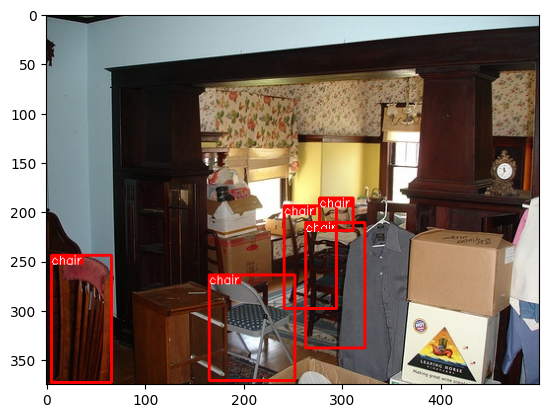

In [5]:
image_with_boxes = get_image_with_bboxes(img, lbl['boxes'], lbl['labels'])
plt.imshow(image_with_boxes)

In [6]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0), transforms.Resize(size=(input_width, input_height))])
img, bboxes, labels = transform(img, lbl['boxes'], lbl['labels'])

down_ratio = 4


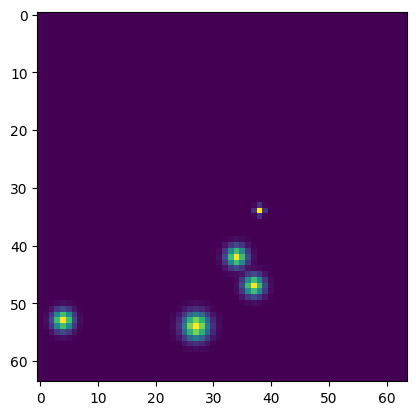

In [7]:
encoder = CenternetEncoder(input_height, input_width)
lbl_encoded = encoder(bboxes, labels)
plt.imshow(lbl_encoded[...,8])

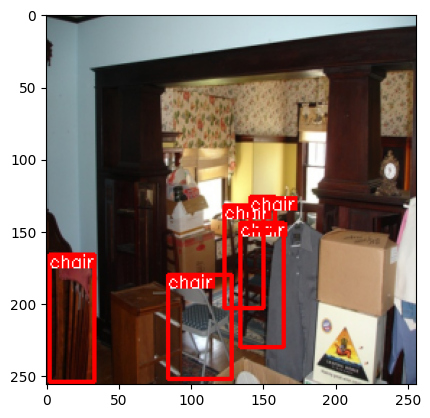

In [8]:
image_with_boxes = get_image_with_bboxes(img,  bboxes, labels)
plt.imshow(image_with_boxes)

In [9]:
hm_chosen = lbl_encoded[...,8]

ind_max = np.argwhere(hm_chosen == np.amax(hm_chosen))
for ind in ind_max:
  print("rect center:", ind * 4)
  print("coors", lbl_encoded[...,20:][ind[0], ind[1]])
  print()

rect center: [136 152]
coors [141. 126. 159. 150.]

rect center: [168 136]
coors [123. 132. 151. 204.]

rect center: [188 148]
coors [134. 144. 165. 231.]

rect center: [212  16]
coors [  2. 166.  34. 255.]

rect center: [216 108]
coors [ 84. 180. 129. 253.]



In [10]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, dataset, transformation, encoder):
        self._dataset = dataset
        self._transformation = transformation
        self._encoder = encoder

    def __getitem__(self, index):
        img, lbl = self._dataset[index]
        img_, bboxes_, labels_ = self._transformation(img, lbl['boxes'], lbl['labels'])
        lbl_encoded = self._encoder(bboxes_, labels_)
        return img_, torch.from_numpy(lbl_encoded)

    def __len__(self):
        return len(self._dataset)

encoder = CenternetEncoder(input_height, input_width)
transform = transforms.Compose([transforms.Resize(size=(input_width, input_height)), transforms.ToTensor()])
torch_dataset = Dataset(dataset=dataset_val, transformation=transform, encoder=encoder)

down_ratio = 4


C:\Users\K\PycharmProjects\I\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
img_, lbl_encoded = torch_dataset[0]
img_.shape, lbl_encoded.shape

(torch.Size([3, 256, 256]), torch.Size([64, 64, 24]))

In [12]:


batch_generator = torch.utils.data.DataLoader(torch_dataset,
                                              batch_size=5,
                                              num_workers=0,
                                              shuffle=False)

In [13]:
input, gt_data = next(iter(batch_generator) )
torch.min(input), torch.max(input)

(tensor(0.), tensor(1.))

In [14]:
input.shape


torch.Size([5, 3, 256, 256])

In [15]:
gt_data.shape

torch.Size([5, 64, 64, 24])

In [16]:
input[0].data.numpy()

array([[[0.03529412, 0.04313726, 0.03921569, ..., 0.64705884,
         0.6431373 , 0.63529414],
        [0.10980392, 0.07450981, 0.05098039, ..., 0.6431373 ,
         0.6431373 , 0.6431373 ],
        [0.37254903, 0.34509805, 0.2901961 , ..., 0.6509804 ,
         0.6509804 , 0.64705884],
        ...,
        [0.07843138, 0.08627451, 0.11372549, ..., 0.26666668,
         0.23921569, 0.22352941],
        [0.1254902 , 0.14117648, 0.20392157, ..., 0.23137255,
         0.23529412, 0.24313726],
        [0.19215687, 0.26666668, 0.30980393, ..., 0.22745098,
         0.24705882, 0.26666668]],

       [[0.03921569, 0.04313726, 0.04705882, ..., 0.73333335,
         0.7372549 , 0.73333335],
        [0.1254902 , 0.07843138, 0.05490196, ..., 0.74509805,
         0.7411765 , 0.7411765 ],
        [0.4117647 , 0.38039216, 0.31764707, ..., 0.7529412 ,
         0.7490196 , 0.7411765 ],
        ...,
        [0.03137255, 0.03137255, 0.03137255, ..., 0.30980393,
         0.28235295, 0.2627451 ],
        [0.0

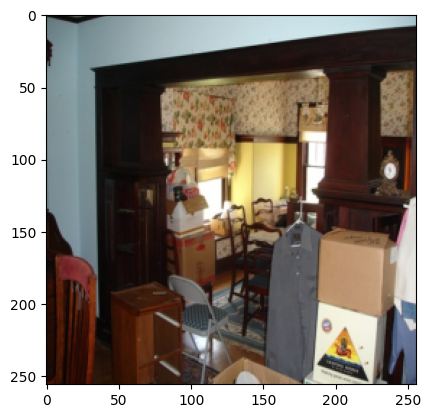

In [17]:
plt.imshow(input[0].data.numpy().transpose(1,2,0))

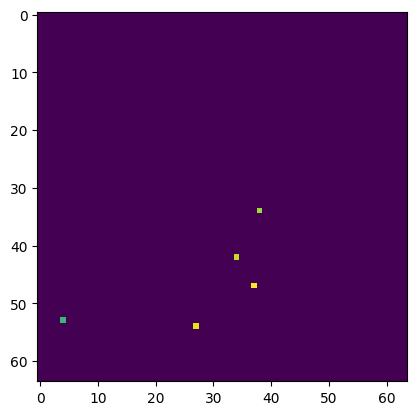

In [18]:
plt.imshow(gt_data[0].data.numpy().sum(axis=2))

In [19]:
class Backbone(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.block_num = 1
        self.alpha = alpha
        self.filters = np.array([64 * self.alpha, 128 * self.alpha, 256 * self.alpha, 512 * self.alpha, 512 * self.alpha]).astype('int')
        s = self.filters
        self.layer1 = self.conv_bn_relu( 3,   s[0], False)
        self.layer2 = self.conv_bn_relu(s[0], s[0], True)  # stride 2
        self.layer3 = self.conv_bn_relu(s[0], s[1], False)
        self.layer4 = self.conv_bn_relu(s[1], s[1], True) # stride 4
        self.layer5 = self.conv_bn_relu(s[1], s[2], False)
        self.layer6 = self.conv_bn_relu(s[2], s[2], False)
        self.layer7 = self.conv_bn_relu(s[2], s[2], True) # stride 8
        self.layer8 = self.conv_bn_relu(s[2], s[3], False)
        self.layer9 = self.conv_bn_relu(s[3], s[3], False)
        self.layer10 = self.conv_bn_relu(s[3], s[3], True) # stride 16
        self.layer11 = self.conv_bn_relu(s[4], s[4], False)
        self.layer12 = self.conv_bn_relu(s[4], s[4], False)
        self.layer13 = self.conv_bn_relu(s[4], s[4], True) # stride 32

    def conv_bn_relu(self, input_num, output_num, max_pool=False, kernel_size=3):
        block = OrderedDict()
        block["conv_" + str(self.block_num)] = nn.Conv2d(input_num, output_num, kernel_size=kernel_size, stride=1, padding=1)
        block["bn_" + str(self.block_num)] = nn.BatchNorm2d(output_num, eps=1e-3, momentum=0.01)
        block["relu_" + str(self.block_num)] = nn.ReLU()
        if max_pool:
            block["pool_" + str(self.block_num)] = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.block_num += 1
        return nn.Sequential(block)

    def forward(self, x):
        out = self.layer1(x)
        out_stride_2 = self.layer2(out)
        out = self.layer3(out_stride_2)
        out_stride_4 = self.layer4(out)
        out = self.layer5(out_stride_4)
        out = self.layer6(out)
        out_stride_8 = self.layer7(out)
        out = self.layer8(out_stride_8)
        out = self.layer9(out)
        out_stride_16 = self.layer10(out)
        out = self.layer11(out_stride_16)
        out = self.layer12(out)
        out_stride_32 = self.layer13(out)
        return out_stride_2, out_stride_4, out_stride_8, out_stride_16, out_stride_32

In [20]:
class Head(nn.Module):
    def __init__(self, backbone_output_filters, class_number=20):
        super().__init__()
        self.connection_num = 3
        self.class_number = class_number
        self.backbone_output_filters = backbone_output_filters
        self.filters = [128, 64, 32]
        head_filters = [self.backbone_output_filters[-1]] + self.filters

        for i, filter_num in enumerate(self.filters):
            name = f'head_{i+1}'
            setattr(self, name, self.conv_bn_relu(name, head_filters[i], head_filters[i+1]))
            # create connection with backbone
            if i < self.connection_num:
                name = f'after_{-2-i}'
                setattr(self, name, self.conv_bn_relu(name, self.backbone_output_filters[-2-i],self.filters[i], 1))

        self.before_hm = self.conv_bn_relu("before_hm", self.filters[-1], self.filters[-1])
        self.before_sizes = self.conv_bn_relu("before_sizes", self.filters[-1], self.filters[-1])

        self.hm = self.conv_bn_relu("hm", self.filters[-1], self.class_number, 3, "sigmoid")
        self.sizes =  self.conv_bn_relu("hm", self.filters[-1], 4, 3, None)

    def conv_bn_relu(self, name, input_num, output_num, kernel_size=3, activation="relu"):
        block = OrderedDict()
        padding = 1 if kernel_size==3 else 0
        block["conv_" + name] = nn.Conv2d(input_num, output_num, kernel_size=kernel_size, stride=1, padding=padding)
        block["bn_" + name] = nn.BatchNorm2d(output_num, eps=1e-3, momentum=0.01)
        if activation == "relu":
            block["relu_" + name] = nn.ReLU()
        elif activation == "sigmoid":
            block["sigmoid_" + name] = nn.Sigmoid()
        return nn.Sequential(block)

    def connect_with_backbone(self, *backbone_out):
        used_out = [backbone_out[-i-2] for i in range(self.connection_num)]
        x = backbone_out[-1]
        for i in range(len(self.filters)):
            x = getattr(self, 'head_{}'.format(i+1))(x)
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            if i < self.connection_num:
                name = f'after_{-2-i}'
                x_ = getattr(self, name)(used_out[i])
                x = torch.add(x, x_)
        return x

    def forward(self, *backbone_out):
        self.last_shared_layer = self.connect_with_backbone(self, *backbone_out)
        x = self.before_hm(self.last_shared_layer)
        hm_out = self.hm(x)

        x = self.before_sizes(self.last_shared_layer)
        sizes_out = self.sizes(x)

        x = torch.cat((hm_out, sizes_out), dim=1)
        return x


In [21]:
class ModelBuilder(nn.Module):
    """
    To connect head with backbone
    """
    def __init__(self, alpha=1.0, class_number=20):
        super().__init__()
        self.class_number = class_number
        self.backbone = Backbone(alpha)
        self.head = Head(backbone_output_filters=self.backbone.filters, class_number=class_number)
        self.loss = CenternetTTFLoss(class_number, 4, input_height//4, input_width//4)
    def forward(self, x, gt=None):
        x = x / 0.5 - 1.0     # normalization
        out = self.backbone(x)
        pred = self.head(*out)

        if gt is None:
            return pred
        else:
            loss = self.loss(gt, pred)
            return loss

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModelBuilder(alpha=0.25).to(device)
summary(model, input_size = (3, 256, 256), batch_size = -1)

loss_dict = {}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
         MaxPool2d-7         [-1, 16, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]           4,640
       BatchNorm2d-9         [-1, 32, 128, 128]              64
             ReLU-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]           9,248
      BatchNorm2d-12         [-1, 32, 128, 128]              64
             ReLU-13         [-1, 32, 128, 128]               0
        MaxPool2d-14    

In [39]:
lr = 0.001
parameters = list(model.parameters())
optimizer = torch.optim.Adam(parameters, lr= 0.01)


In [40]:
EPOCHS = 30
model.eval()
model.train(True)

for epoch in range(EPOCHS):
  print('EPOCH {}:'.format(epoch + 1))
  for i, data in enumerate(batch_generator):
    input, gt_data = data
    input = input.to(device).contiguous()

    gt_data = gt_data.to(device)
    gt_data.requires_grad = False

    loss_dict = model(input, gt=gt_data)
    optimizer.zero_grad() # compute gradient and do optimize step
    loss_dict['loss'].backward()

    optimizer.step()

    print(loss_dict['loss'])


EPOCH 1:
tensor(66.2013, grad_fn=<AddBackward0>)
tensor(99.1608, grad_fn=<AddBackward0>)
tensor(44.0907, grad_fn=<AddBackward0>)
tensor(50.9642, grad_fn=<AddBackward0>)
tensor(98.0446, grad_fn=<AddBackward0>)
tensor(91.9038, grad_fn=<AddBackward0>)
EPOCH 2:
tensor(63.9081, grad_fn=<AddBackward0>)
tensor(80.2340, grad_fn=<AddBackward0>)
tensor(35.4437, grad_fn=<AddBackward0>)
tensor(43.4171, grad_fn=<AddBackward0>)
tensor(82.7603, grad_fn=<AddBackward0>)
tensor(78.2156, grad_fn=<AddBackward0>)
EPOCH 3:
tensor(55.2026, grad_fn=<AddBackward0>)
tensor(69.3773, grad_fn=<AddBackward0>)
tensor(30.9509, grad_fn=<AddBackward0>)
tensor(38.0968, grad_fn=<AddBackward0>)
tensor(71.8864, grad_fn=<AddBackward0>)
tensor(67.8499, grad_fn=<AddBackward0>)
EPOCH 4:
tensor(48.1486, grad_fn=<AddBackward0>)
tensor(60.6535, grad_fn=<AddBackward0>)
tensor(27.2860, grad_fn=<AddBackward0>)
tensor(33.7928, grad_fn=<AddBackward0>)
tensor(63.1239, grad_fn=<AddBackward0>)
tensor(59.4003, grad_fn=<AddBackward0>)
EPOC

In [42]:
steps_per_epoch = 1500
model.train()

for step in range(steps_per_epoch):
    # Cycle through the dataset
    input, gt_data = next(iter(batch_generator))

    input = input.to(device).contiguous()
    gt_data = gt_data.to(device)
    gt_data.requires_grad = False

    loss_dict = model(input, gt=gt_data)
    optimizer.zero_grad()
    loss_dict['loss'].backward()
    optimizer.step()

    print(loss_dict['loss'])

tensor(0.4002, grad_fn=<AddBackward0>)
tensor(0.4205, grad_fn=<AddBackward0>)
tensor(0.4006, grad_fn=<AddBackward0>)
tensor(0.4083, grad_fn=<AddBackward0>)
tensor(0.4123, grad_fn=<AddBackward0>)
tensor(0.4020, grad_fn=<AddBackward0>)
tensor(0.4178, grad_fn=<AddBackward0>)
tensor(0.3949, grad_fn=<AddBackward0>)
tensor(0.3971, grad_fn=<AddBackward0>)
tensor(0.4162, grad_fn=<AddBackward0>)
tensor(0.4074, grad_fn=<AddBackward0>)
tensor(0.3949, grad_fn=<AddBackward0>)
tensor(0.3894, grad_fn=<AddBackward0>)
tensor(0.4035, grad_fn=<AddBackward0>)
tensor(0.4055, grad_fn=<AddBackward0>)
tensor(0.3888, grad_fn=<AddBackward0>)
tensor(0.3881, grad_fn=<AddBackward0>)
tensor(0.4037, grad_fn=<AddBackward0>)
tensor(0.3930, grad_fn=<AddBackward0>)
tensor(0.3803, grad_fn=<AddBackward0>)
tensor(0.3872, grad_fn=<AddBackward0>)
tensor(0.3805, grad_fn=<AddBackward0>)
tensor(0.3976, grad_fn=<AddBackward0>)
tensor(0.3818, grad_fn=<AddBackward0>)
tensor(0.3896, grad_fn=<AddBackward0>)
tensor(0.3686, grad_fn=<A

KeyboardInterrupt: 